In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../scripts")
import evaluate
import utils
import tensorflow as tf
import numpy as np
# import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
import saliency_embed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
testset, targets = evaluate.collect_whole_testset('../../datasets/quantitative_data/testset/', coords=True)
np_C, np_X, np_Y = utils.convert_tfr_to_np(testset)

2022-04-01 16:18:34.377190: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 16:18:34.865812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14036 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [5]:
# load and get model layer
run_path = glob.glob('../../trained_models/**/run-20211023_095131-w6okxt01', recursive=True)[0]
layer = -3
model, bin_size = utils.read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

In [6]:
threshold = 2
cell_line = 13
print(targets[cell_line])
thresholded_C, thresholded_X, thresholded_Y = utils.threshold_cell_line_np(np_C, 
                                                                           np_X, 
                                                                           np_Y, 
                                                                           cell_line, 
                                                                           more_than=threshold)
idr_class = saliency_embed.label_idr_peaks(thresholded_C, cell_line, bedfile1='../../datasets/quantitative_data/testset/sequences.bed', 
                                           bedfile2='../../datasets/quantitative_data/cell_line_testsets/cell_line_13/complete/peak_centered/i_2048_w_1.bed', 
                                           fraction_overlap=0.5)
predictions = utils.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
interm_representations = utils.predict_np(thresholded_X, aux_model, batch_size=32, reshape_to_2D=True)

thresholded_Y.shape

PC-3


2022-04-01 16:19:44.793157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-01 16:19:46.586552: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(23346, 2048)

In [7]:
embeddings = saliency_embed.get_embeddings(interm_representations)
embeddings['IDR'] = idr_class
embeddings['cell line'] = targets[cell_line]

In [8]:
embeddings.to_csv('../tutorial_outputs/UMAP_embeddings.csv', index=None)

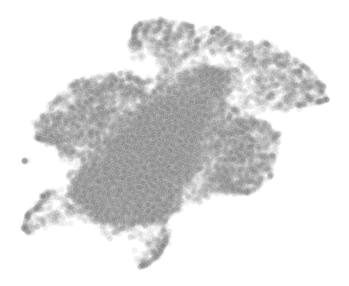

In [11]:
fig, ax = plt.subplots(1,figsize=[6,5])

ax = sns.scatterplot(data=embeddings,
               x='UMAP 1', y='UMAP 2',
               alpha=0.1, 
               color='grey',
               ax=ax)
ax.set_axis_off()

../tutorial_outputs/saliency_maps/test_maps.svg


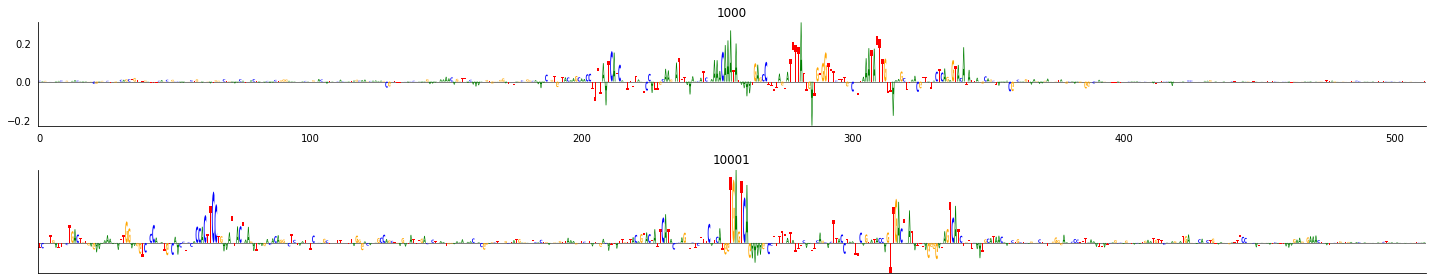

In [14]:
saliency_cell_line_dir = utils.make_dir('../tutorial_outputs/saliency_maps')
sets_of_ids = {'test_maps':[1000, 10001]}

for label,selected_sample_ids in sets_of_ids.items():
    output_path = os.path.join(saliency_cell_line_dir, label+'.svg')
    print(output_path)
    explainer = saliency_embed.Explainer(model, class_index=cell_line)
    X_sample = thresholded_X[selected_sample_ids]
    saliency_scores = explainer.saliency_maps(X_sample)
    saliency_embed.plot_saliency_logos_oneplot(saliency_scores, X_sample, window=256, 
                                    titles = selected_sample_ids,
                                    filename=output_path)